In [103]:
import cvx_ha
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from scipy.optimize import minimize
import cvxpy
sns.set_style('white')

# #2 on a simplex
Here we go, some of math is written in latex as it is incredibly hard to write with latex here a lot.

In [179]:
def get_A_b(n=10):
    torch.manual_seed(42)
    A = torch.randn(n, n)
    b = torch.randn(n)
    return A, b
A, b = get_A_b()
def f(x, AtA, b):
    return .5 * x @ AtA @ x - b @ x

In [182]:
import collections
Setup = collections.namedtuple('Setup', 'x,A,b,closure,f_star,x_star')
def prepare_experiment(m):
    A, b = get_A_b(m)
    AtA = A.t() @ A
    x0 = torch.ones(m, requires_grad=True)
    x0.data.div_(m)
    def closure():
        y = f(x0, AtA, b)
        y.backward()
        return y.item()
    # solve cvxpy
    _x = cvxpy.Variable(len(x0))
    _AtA = cvxpy.Constant(AtA)
    _b = cvxpy.Constant(b.numpy())
    _obj = cvxpy.Minimize(.5 * cvxpy.QuadForm(_x, _AtA) - _b * _x)
    _wrt = [cvxpy.sum(_x) == 1, _x >= 0]
    solution = cvxpy.Problem(_obj, _wrt).solve()
    return Setup(x0, A, b, closure, solution, torch.tensor(_x.value))

In [183]:
setup = prepare_experiment(1000)

In [184]:
x0 = setup[0].data.clone()
def reset():
    setup[0].data.set_(x0.clone())

In [185]:
def run_proj_sgd(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    opt = cvx_ha.ha1.ProjectedSGD([x], lr=lr0, projection=cvx_ha.ha1.simplex_projection)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    for i in range(iters):
        opt.zero_grad()
        if lr_policy is not None:
            lr_policy.step(i)
        y = opt.step(closure)
        vals.append(y)
        if callback is not None:
            callback(x, y, i)
    return np.asarray(vals)

def run_dual_averaging(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    opt = cvx_ha.ha1.DualAveraging([x], lr=lr0, dual_projection=cvx_ha.ha1.simplex_dual_projection)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    for i in range(iters):
        opt.zero_grad()
        if lr_policy is not None:
            lr_policy.step(i)
        y = opt.step(closure)
        vals.append(y)
        if callback is not None:
            callback(x, y, i)
    return np.asarray(vals)

# https://bayen.eecs.berkeley.edu/sites/default/files/conferences/efficient_bregman_projections.pdf
def run_mirror_bayen(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    opt = cvx_ha.ha1.MirrorDescent([x], lr=lr0, brehman_projection=cvx_ha.ha1.mirror_descent.brehman_exp_simplex_projection)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    for i in range(iters):
        opt.zero_grad()
        if lr_policy is not None:
            lr_policy.step(i)
        y = opt.step(closure)
        vals.append(y)
        if callback is not None:
            callback(x, y, i)
    return np.asarray(vals)

# https://blogs.princeton.edu/imabandit/2013/04/18/orf523-mirror-descent-part-iiii/
def run_mirror_prinston(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    def brehman_project(x, g):
        y = x*(-g).exp()
        return y.div_(y.norm(1))
    bh = cvx_ha.ha1.BregmanProjectionUpdate(closed_form=brehman_project)
    opt = cvx_ha.ha1.MirrorDescent([x], lr=lr0, brehman_projection=bh)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    for i in range(iters):
        opt.zero_grad()
        if lr_policy is not None:
            lr_policy.step(i)
        y = opt.step(closure)
        vals.append(y)
        if callback is not None:
            callback(x, y, i)
    return np.asarray(vals)

In [186]:
def lr_grid(algo, lrs, *args, **kwargs):
    out = []
    for lr in lrs:
        reset()
        out.append(algo(*args, lr0=lr, **kwargs))
    return out

In [196]:
%%time
reset()
results_mirror_bayen = run_mirror_bayen(setup.x, setup.closure, lr0=1e-2)
reset()
results_mirror_prinston = run_mirror_prinston(setup.x, setup.closure, lr0=1e-2)
reset()
results_sgd = run_proj_sgd(setup.x, setup.closure, lr0=1/(10*1600)**.5)
reset()
results_dualavg = run_dual_averaging(setup.x, setup.closure, lr0=1/1600**.5)

CPU times: user 1min 47s, sys: 947 ms, total: 1min 48s
Wall time: 1min 45s


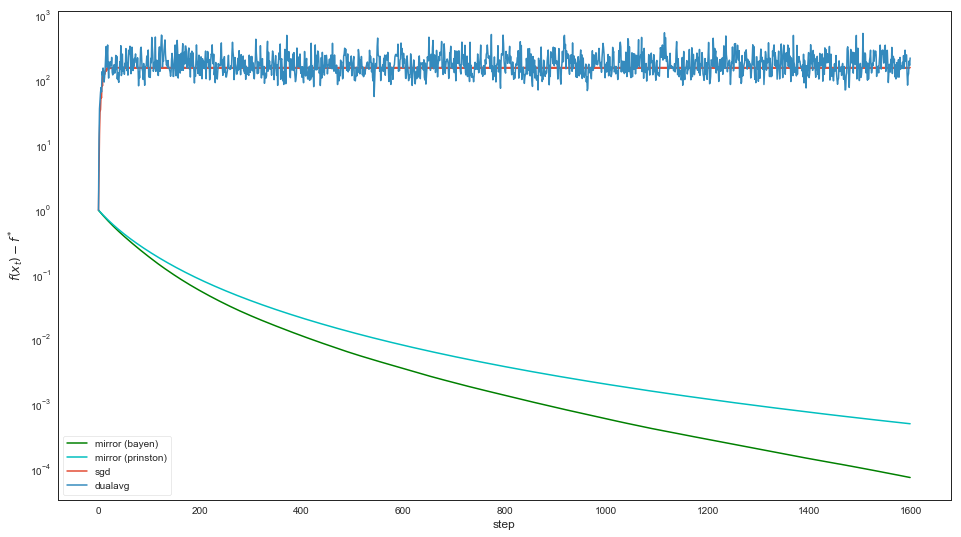

In [197]:
plt.figure(figsize=(16, 9))
plt.plot(results_mirror_bayen-setup.f_star, c='g', label='mirror (bayen)')
plt.plot(results_mirror_prinston-setup.f_star, c='c', label='mirror (prinston)')
plt.plot(results_sgd-setup.f_star, label='sgd')
plt.plot(results_dualavg-setup.f_star, label='dualavg')
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$f(x_t)-f^*$');
plt.legend()

AMAzing, mirror descent was the only one that coped with the problem (with default stepsize policy)
But learning rate policy seemed not to be obviously defined. Here I found fixed small enough stepsize working the best